In [ ]:
import numpy as np
import pandas as pd
import torch

In [ ]:
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
start_time = datetime.now()

In [ ]:
class RestrictedBoltzmannMachine():
    """
    Python implementation of a Restricted Boltzmann Machine (RBM) with 'c_nh' hidden nodes and 'c_nv' visible nodes.
    """
    def __init__(self, c_nv, c_nh):
        """
        RBM initialization module where three tensors are defined:
        W - Weight tensor
        a - Visible node bias tensor
        b - Hidden node bias tensor
        a and b are created as two-dimensional tensors to accommodate batches of observations over training.
        """
        self.W = torch.randn(c_nh, c_nv)
        self.a = torch.randn(1, c_nh)
        self.b = torch.randn(1, c_nv)


    def sample_h(self, c_vx):
        """
        Method devoted to Gibbs sampling probabilities of hidden nodes given visible nodes - p (h|v)
        c_vx - Input visible node tensor
        """
        c_w_vx = torch.mm(c_vx, self.W.t())
        c_activation = c_w_vx + self.a.expand_as(c_w_vx)
        c_p_h_given_v = torch.sigmoid(c_activation)
        return c_p_h_given_v, torch.bernoulli(c_p_h_given_v)


    def sample_v(self, c_hx):
        """
        Method devoted to Gibbs sampling probabilities of visible nodes given hidden nodes - p (v|h)
        c_hx - Input hidden node tensor
        """
        c_w_hx = torch.mm(c_hx, self.W)
        c_activation = c_w_hx + self.b.expand_as(c_w_hx)
        c_p_v_given_h = torch.sigmoid(c_activation)
        return c_p_v_given_h, torch.bernoulli(c_p_v_given_h)


    def train(self, c_nr_observations, c_nr_epoch, c_batch_size, c_train_tensor, c_metric):
        """
        Method through which contrastive divergence-based training is performed.
        c_nr_observations - Number of observations used for training
        c_nr_epoch - Number of training epochs
        c_batch_size - Batch size
        c_train_tensor - Tensor containing training observations
        c_metric - Training performance metric of choice ('MAbsE' for Mean Absolute Error, 'RMSE' for Root Mean Square Error)
        """
        print('Training...')
        for c_epoch in range(1, c_nr_epoch + 1):
            c_start_time = datetime.now()
            print(f'Epoch {str(c_epoch)} of {str(c_nr_epoch)} ', end='')
            c_train_loss = 0
            c_s = 0.
            for c_id_user in range(0, c_nr_observations - c_batch_size, c_batch_size):
                c_v0 = c_train_tensor[c_id_user:c_id_user+c_batch_size]
                c_vk = c_train_tensor[c_id_user:c_id_user+c_batch_size]
                c_ph0,_ = self.sample_h(c_v0)
                for c_k in range(10):
                    _,c_hk = self.sample_h(c_vk)
                    _,c_vk = self.sample_v(c_hk)
                    c_vk[c_v0<0] = c_v0[c_v0<0]
                c_phk,_ = self.sample_h(c_vk)
                self.W += (torch.mm(c_v0.t(), c_ph0) - torch.mm(c_vk.t(), c_phk)).t()
                self.b += torch.sum((c_v0 - c_vk), 0)
                self.a += torch.sum((c_ph0 - c_phk), 0)
                if c_metric == 'MAbsE':
                    c_train_loss += torch.mean(torch.abs(c_v0[c_v0>=0] - c_vk[c_v0>=0]))
                elif c_metric == 'RMSE':
                    c_train_loss += np.sqrt(torch.mean((c_v0[c_v0>=0] - c_vk[c_v0>=0])**2))
                c_s += 1.
            c_end_time = datetime.now()
            c_time_elapsed = c_end_time - c_start_time
            c_time_elapsed = c_time_elapsed.total_seconds()
            print(f'- Loss ({c_metric}): {c_train_loss/c_s:.8f} ({c_time_elapsed:.2f} seconds)')


    def test(self, c_nr_observations, c_train_tensor, c_test_tensor, c_metric):
        """
        Method through which testing is performed.
        c_nr_observations - Number of observations used for testing
        c_train_tensor - Tensor containing training observations
        c_test_tensor - Tensor containing testing observations
        c_metric - Training performance metric of choice ('MAbsE' for Mean Absolute Error, 'RMSE' for Root Mean Square Error)
        """
        print('Testing...')
        c_test_loss = 0
        c_s = 0.
        for c_id_user in range(c_nr_observations):
            c_v = c_train_tensor[c_id_user:c_id_user+1]
            c_vt = c_test_tensor[c_id_user:c_id_user+1]
            if len(c_vt[c_vt>=0]) > 0:
                _,c_h = self.sample_h(c_v)
                _,c_v = self.sample_v(c_h)
                if c_metric == 'MAbsE':
                    c_test_loss += torch.mean(torch.abs(c_vt[c_vt>=0] - c_v[c_vt>=0]))
                elif c_metric == 'RMSE':
                    c_test_loss += np.sqrt(torch.mean((c_vt[c_vt>=0] - c_v[c_vt>=0])**2))
                c_s += 1.
        print(f'Test loss ({c_metric}): {c_test_loss/c_s:.8f}')


    def predict(self, c_visible_nodes):
        """
        Method through which predictions for one specific observation are derived.
        c_visible_nodes - Tensor containing one particular observation (set of values for each visible node)
        """
        c_h_v,_ = self.sample_h(c_visible_nodes)
        c_v_h,_ = self.sample_v(c_h_v)
        return c_v_h

In [ ]:
def convert(f_data, f_nr_observations, f_nr_entities):
        """
        Generates (from a numpy array) a list of lists containing the number of hits per user (rows), per entity (columns).
        Each of the constituent lists will correspond to an observation / user (row).
        Each observation list will contain the number of hits (columns), one for each hit entity
        f_data - Input table (numpy array)
        f_nr_observations - Number of observations
        f_nr_entities - Number of entities hit in each observation
        """
        f_converted_data = []
        for f_id_user in range(1, f_nr_observations + 1):
            f_id_entity = f_data[:,1][f_data[:,0] == f_id_user].astype(int)
            f_id_hits = f_data[:,2][f_data[:,0] == f_id_user]
            f_hits = np.zeros(f_nr_entities)
            f_hits[f_id_entity - 1] = f_id_hits
            f_converted_data.append(list(f_hits))
        return f_converted_data


In [ ]:
def preferred_recommended(f_artist_list, f_train_set, f_test_set, f_model, f_user_id, f_top=10):
        """
        Generates music artist recommendations for a particular platform user.
        f_artist_list - List of artists and corresponding IDs
        f_train_set - Tensor containing training observations
        f_test_set - Tensor containing testing observations
        f_model - A RBM machine learning model previously instantiated
        f_user_id - The user for which preferred artists will be assessed and recommendations will be provided
        f_top - Number of most preferred and most recommended music artists for user 'f_user_id'
        """
        if f_user_id < 1515:
            f_user_sample = f_train_set[f_user_id - 1:f_user_id]
        else:
            f_user_sample = f_test_set[f_user_id - 1:f_user_id]
        f_prediction = f_model.predict(f_user_sample).numpy()
        f_user_sample = f_user_sample.numpy()
        f_user_sample = pd.Series(f_user_sample[0])
        f_user_sample = f_user_sample.sort_values(ascending=False)
        f_user_sample = f_user_sample.iloc[:f_top]
        f_fan_list = f_user_sample.index.values.tolist()
        print(f'\nUser {f_user_id} is a fan of...\n')
        for f_artist_id in f_fan_list:
            print(f_artist_list[f_artist_list.artist_id == f_artist_id + 1].iloc[0][1])
        f_prediction = pd.Series(f_prediction[0])
        f_prediction = f_prediction.sort_values(ascending=False)
        f_prediction_list = f_prediction.index.values.tolist()
        print(f'\nUser {f_user_id} may be interested in...\n')
        f_nb_recommendations = 0
        f_i = 0
        while f_nb_recommendations < f_top:
            f_pred_artist = f_prediction_list[f_i]
            if f_pred_artist not in f_fan_list:
                print(f_artist_list[f_artist_list.artist_id == f_pred_artist + 1].iloc[0][1])
                f_nb_recommendations += 1
            f_i += 1

In [ ]:
import pandas as pd
scrobbles = pd.read_csv('/content/lastfm_user_scrobbles.csv', header = 0)
scrobbles.head()

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690
2,1,494,11351
3,1,6673,10300
4,1,8402,8983


In [ ]:
scrobbles['scrobbles'] = scrobbles.groupby('user_id')['scrobbles'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
scrobbles['scrobbles'] = scrobbles['scrobbles'].fillna(0.5)
scrobbles.head()

,user_id,artist_id,scrobbles
0,1,4562,1.000000
1,1,10191,0.825509
2,1,494,0.798536
3,1,6673,0.714911
4,1,8402,0.610121


In [ ]:
scrobbles.head()

,user_id,artist_id,scrobbles
0,1,4562,1.000000
1,1,10191,0.825509
2,1,494,0.798536
3,1,6673,0.714911
4,1,8402,0.610121


from matplotlib import pyplot as plt
_df_0['artist_id'].plot(kind='hist', bins=20, title='artist_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['scrobbles'].plot(kind='hist', bins=20, title='scrobbles')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='artist_id', y='scrobbles', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_id']
  ys = series['artist_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('artist_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_id']
  ys = series['scrobbles']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('scrobbles')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user_id'}, axis=1)
              .sort_values('user_id', ascending=True))
  xs = counted['user_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('user_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['artist_id'].plot(kind='line', figsize=(8, 4), title='artist_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['scrobbles'].plot(kind='line', figsize=(8, 4), title='scrobbles')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

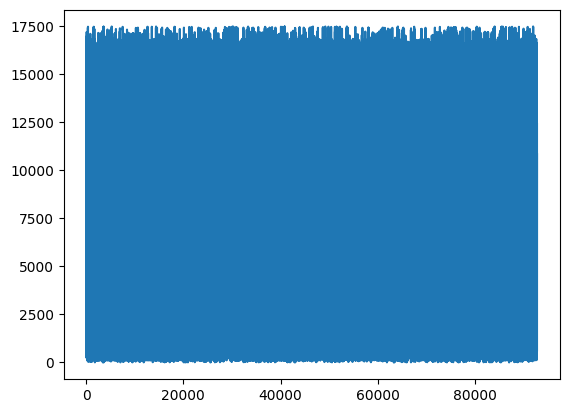

In [ ]:
a_id=scrobbles['artist_id']
a_id.plot()

In [ ]:
scrobbles.isnull().sum()

user_id      0
artist_id    0
scrobbles    0
dtype: int64

<Axes: >

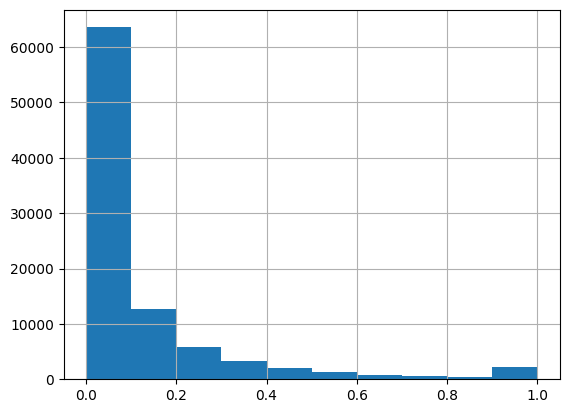

In [ ]:
scrobbles['scrobbles'].hist()

<Axes: xlabel='artist_id', ylabel='scrobbles'>

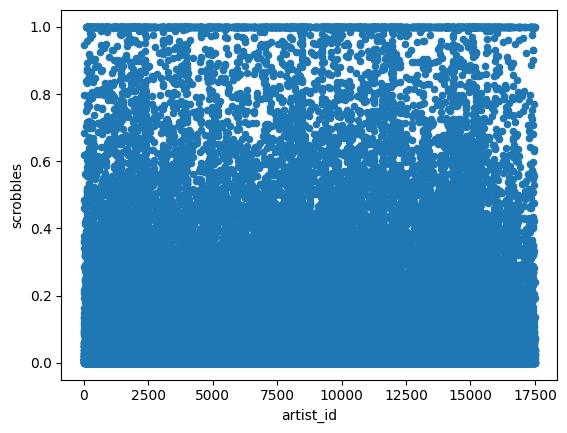

In [ ]:
scrobbles.plot.scatter(x='artist_id', y='scrobbles')

In [ ]:
scrobbles.groupby('artist_id')['scrobbles'].sum()

artist_id
1        0.049678
2        0.019264
3        0.011076
4        0.187333
5        0.045123
           ...   
17489    0.243524
17490    1.000000
17491    0.241542
17492    0.054735
17493    0.001163
Name: scrobbles, Length: 17493, dtype: float64

In [ ]:
training_size = 74254
training_set = scrobbles.iloc[:training_size, :]  # Until userID = 1514
test_set = scrobbles.iloc[training_size:, :]      # Starting at userID = 1515

training_set = training_set.values
test_set = test_set.values

training_set.shape, test_set.shape

((74254, 3), (18538, 3))

In [ ]:
nr_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nr_artists = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [ ]:
nr_users, nr_artists

(1892, 17493)

In [ ]:
training_set = convert(training_set, nr_users, nr_artists)
test_set = convert(test_set, nr_users, nr_artists)

In [ ]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)